In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import math
import pytesseract
from PIL import Image, ImageEnhance
import numpy as np
import pdf2image
import cv2

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /home/cvk/mmocr/
!ls

import cv2
import math
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
from mmocr.utils.ocr import MMOCR
from sklearn.cluster import KMeans
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression

from IPython.display import display, HTML
import pandas as pd
%matplotlib inline

1.7.0+cu110 True
2.18.0
1.3.17
11.0
GCC 7.3
0.3.0
/home/cvk/mmocr
 annot				 output_hocr.hocr
 annotations.ipynb		 output_hocr.txt
 annotorious-openseadragon	 outputs
 bounding_boxes.csv		 package-lock.json
 box.png			 plot_rank_filters.ipynb
 CITATION.cff			 README.md
 configs			 README_zh-CN.md
 data				 requirements
 default10000.png		 requirements.txt
 demo				 resources
 docker				 result100.png
 docs				 result100.txt
 docs_zh_CN			 result1.csv
 east_coco.ipynb		 result.csv
 edges-50-150.jpg		 result.png
 example1.pdf			 setup.cfg
 example2.pdf			 setup.py
 example3.pdf			 TableOCR.ipynb
 example4.pdf			 TableOCR-Kmeans.ipynb
 example5.pdf			'TableWithGridLayoutOCR 1.01.ipynb'
 example6.pdf			 temp.png
 example7.pdf			 tesseract_mmocr.ipynb
 example.pdf			 test100.csv
 Final_round_mmocr-Copy1.ipynb	 test10.csv
 Final_round_mmocr-Copy2.ipynb	 test1.csv
 Final_round_mmocr-Copy3.ipynb	 test5.csv
 Final_round_mmocr-Copy4.ipynb	 test6.csv
 Final_round_mmocr.ipynb	 test7.csv
 frozen_ea

In [3]:
def convert_pdf_to_image(document, dpi):
    images = []
    images.extend(
                    list(
                        map(
                            lambda image: cv2.cvtColor(
                                np.asarray(image), code=cv2.COLOR_RGB2BGR
                            ),
                            pdf2image.convert_from_path(document, dpi=dpi),
                        )
                    )
                )
    return images

In [4]:
images = convert_pdf_to_image('example.pdf',300)

In [5]:
print(len(images))

4


In [6]:
print(images[0].shape)

(3435, 2409, 3)


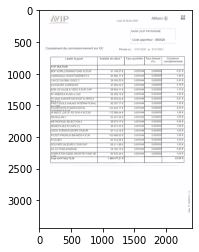

In [7]:
first_page = images[2]
plt.imshow(first_page)

In [8]:
def set_image_dpi(first_page):
    """
    Rescaling image to 300dpi without resizing
    :param image: An image
    :return: A rescaled image
    """
    image_resize = first_page
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    temp_filename = temp_file.name
    image_resize.save(temp_filename, dpi=(300, 300))
    return temp_filename

In [9]:
import cv2

# Load image, convert to grayscale, Otsu's threshold
image = first_page
result = image.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=6)
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
yLines = []
for c in cnts:
    cv2.drawContours(result, [c], -1, (36,255,12), 2)
    yLines.append(c[0][0][1])

# Detect vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,10))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=6)
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
xLines=[]
for c in cnts:
    cv2.drawContours(result, [c], -1, (36,255,12), 2)
    xLines.append(c[0][0][0])

    xLines.sort()
yLines.sort()
cv2.imwrite('demo/ddd05.png', result)

print('xlines', xLines) 
print('yLines', yLines)
print(len(xLines))
print(len(yLines))

xlines [184, 914, 1339, 1340, 1658, 1659, 1930, 1933, 2237, 2287]
yLines [734, 864, 935, 1009, 1080, 1152, 1225, 1297, 1369, 1442, 1514, 1587, 1659, 1731, 1801, 1873, 1945, 2018, 2090, 2163, 2235, 2309, 2404]
10
23


In [10]:
#Filter duplicates lines in xLines
tmp = []
for x in xLines:
    if len(tmp) > 0 and x >= tmp[-1] + 5:
        tmp.append(x)
    elif len(tmp) == 0:
        tmp.append(x)
xLines = tmp
#Filter duplicates lines in yLines
tmp = []
for y in yLines:
    if len(tmp) > 0 and y >= tmp[-1] + 5:
        tmp.append(y)
    elif len(tmp) == 0:
        tmp.append(y)
        
yLines = tmp

In [11]:
print(len(xLines))
print(len(yLines))
print('xlines', xLines) 
print('yLines', yLines)

7
23
xlines [184, 914, 1339, 1658, 1930, 2237, 2287]
yLines [734, 864, 935, 1009, 1080, 1152, 1225, 1297, 1369, 1442, 1514, 1587, 1659, 1731, 1801, 1873, 1945, 2018, 2090, 2163, 2235, 2309, 2404]


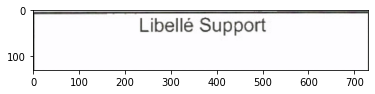

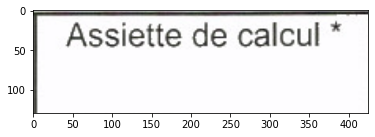

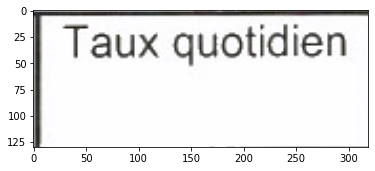

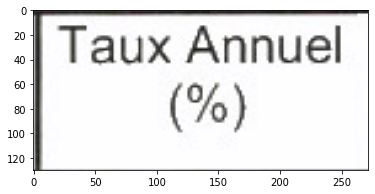

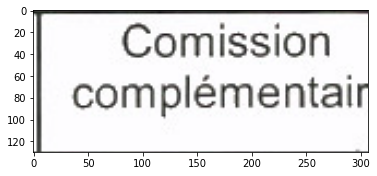

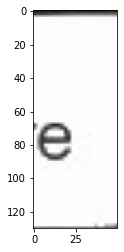

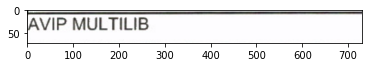

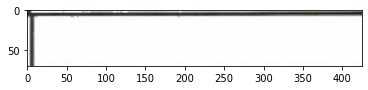

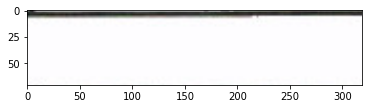

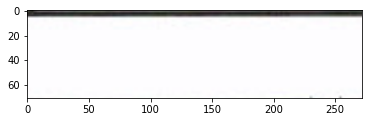

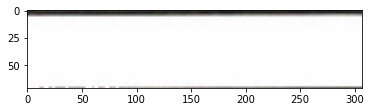

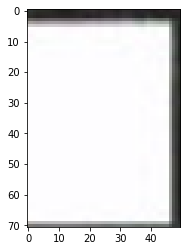

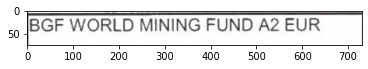

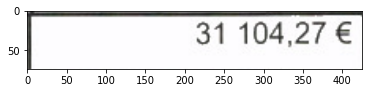

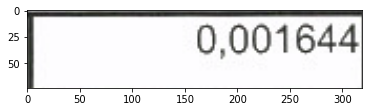

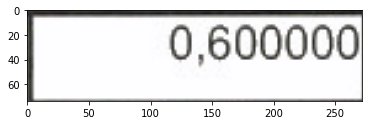

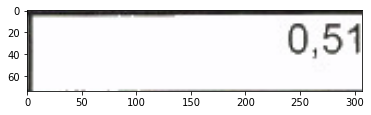

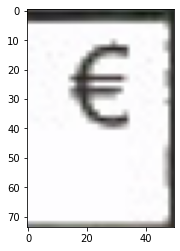

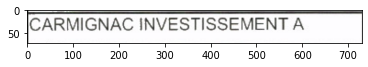

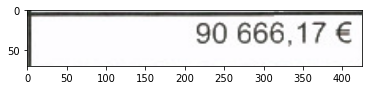

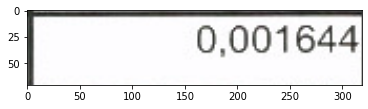

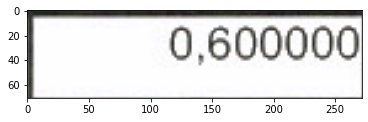

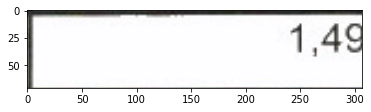

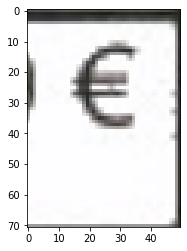

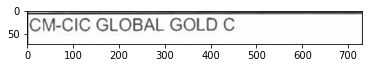

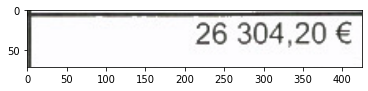

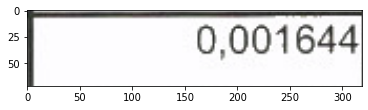

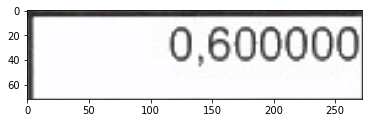

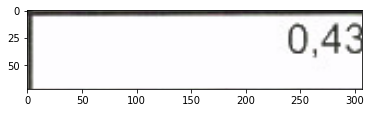

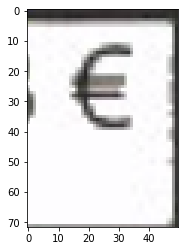

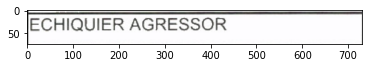

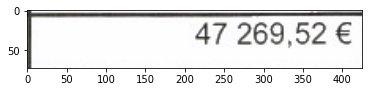

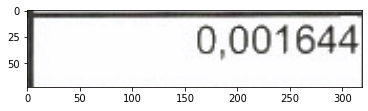

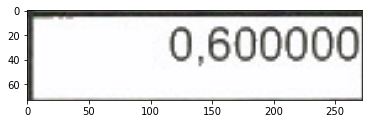

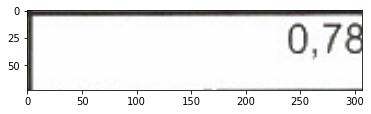

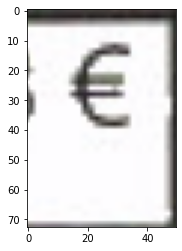

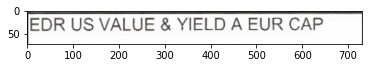

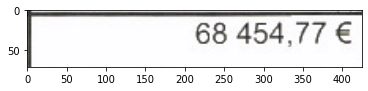

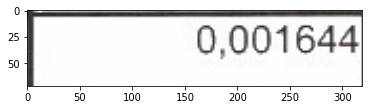

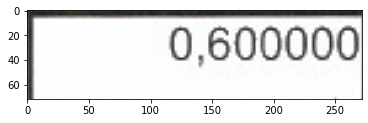

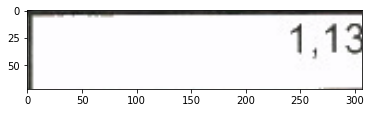

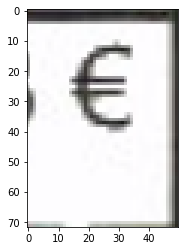

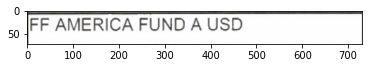

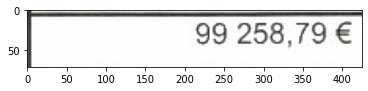

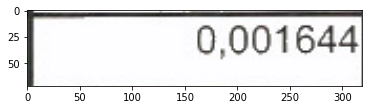

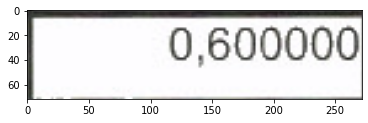

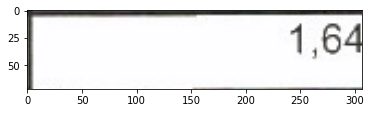

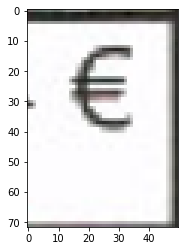

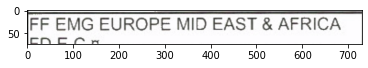

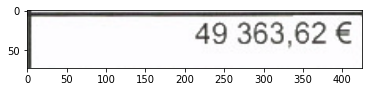

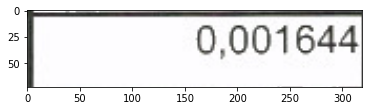

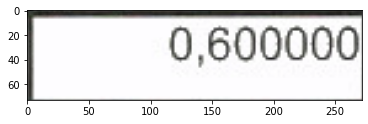

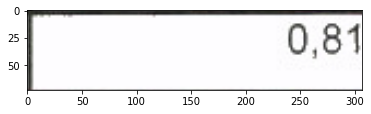

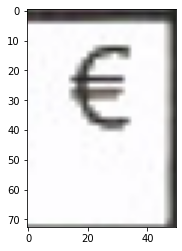

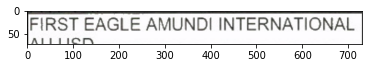

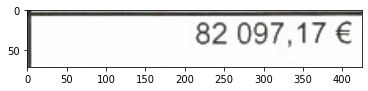

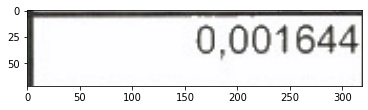

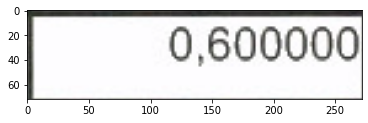

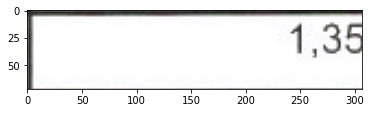

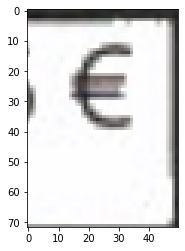

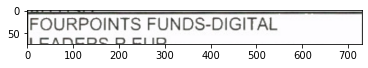

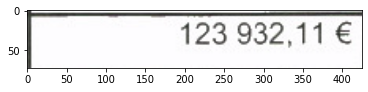

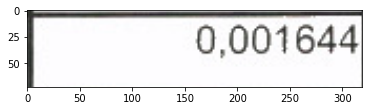

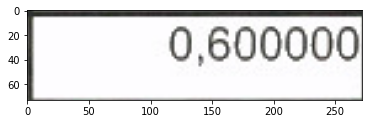

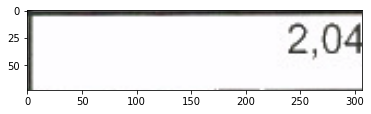

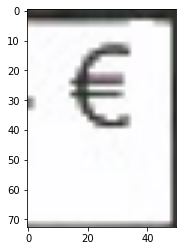

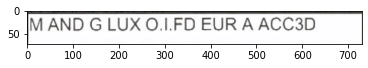

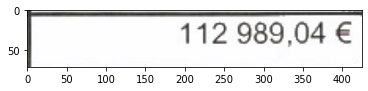

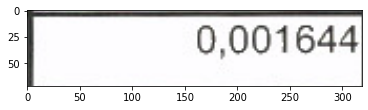

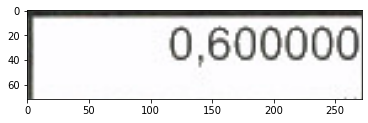

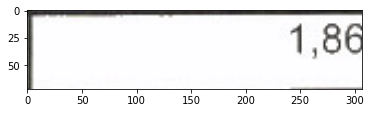

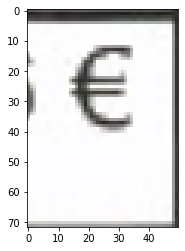

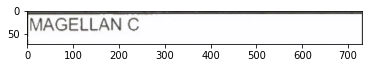

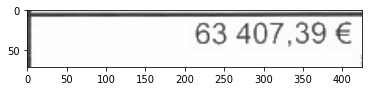

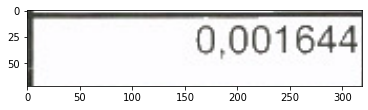

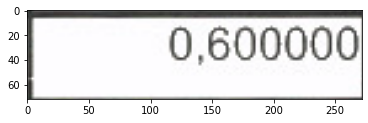

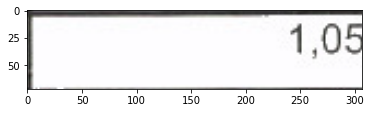

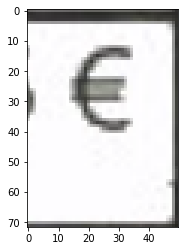

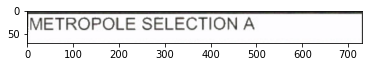

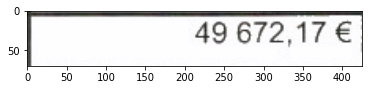

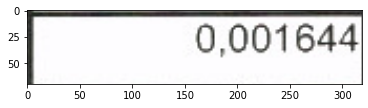

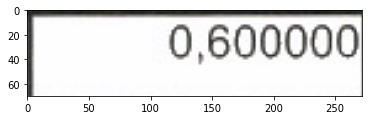

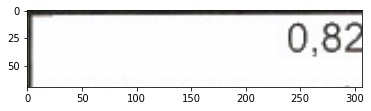

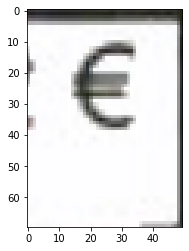

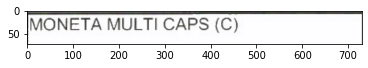

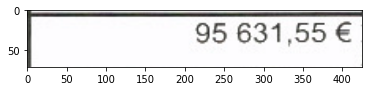

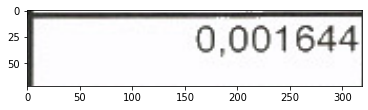

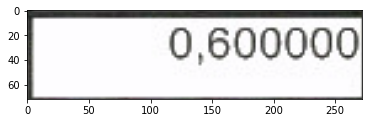

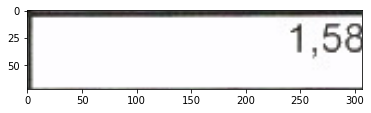

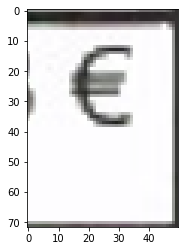

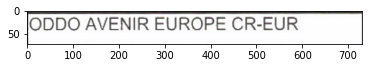

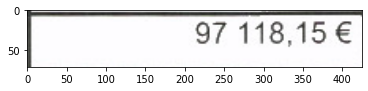

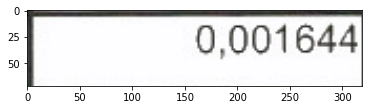

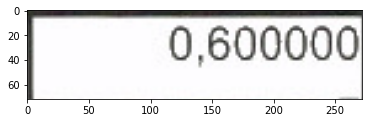

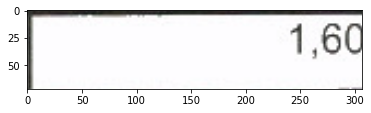

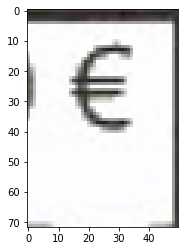

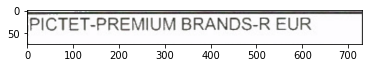

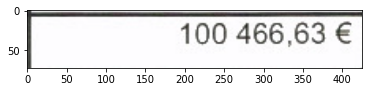

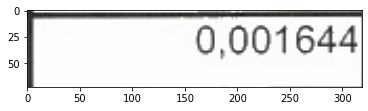

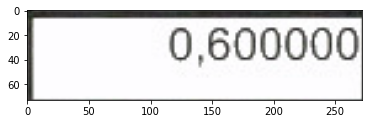

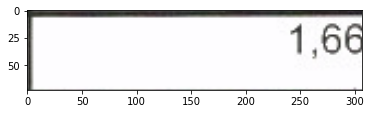

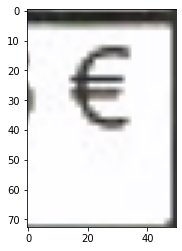

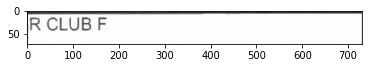

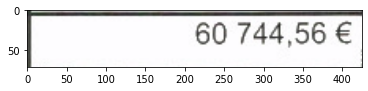

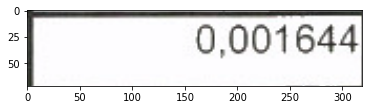

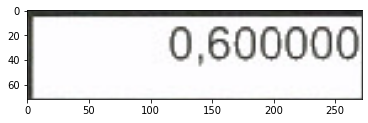

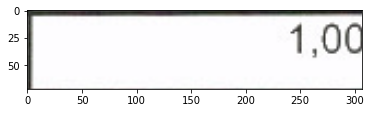

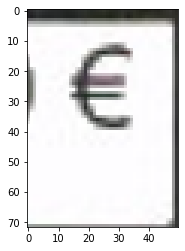

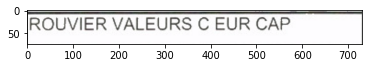

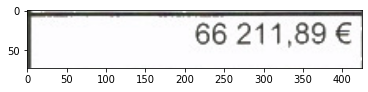

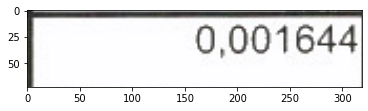

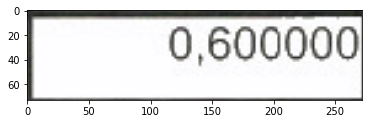

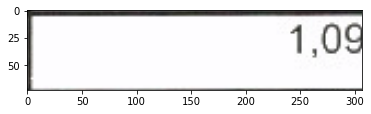

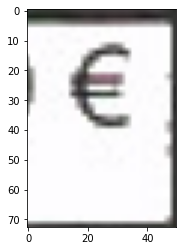

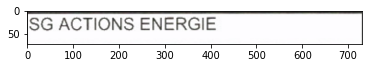

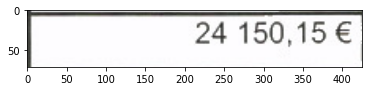

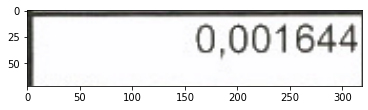

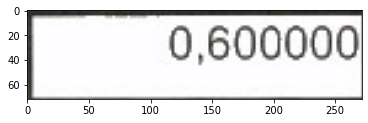

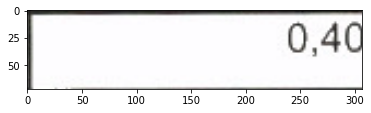

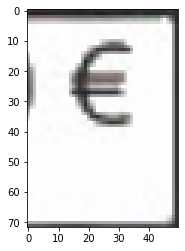

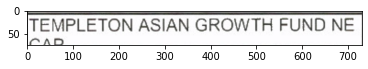

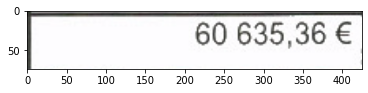

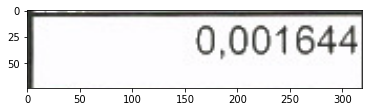

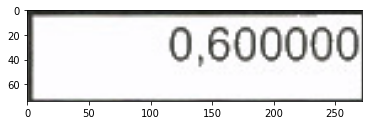

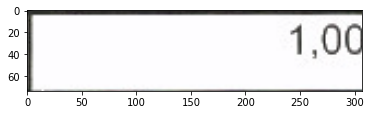

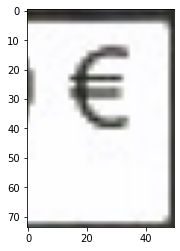

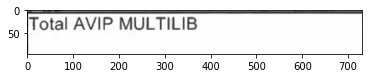

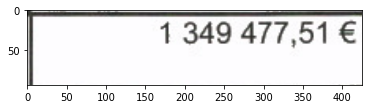

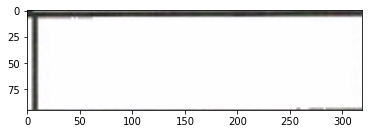

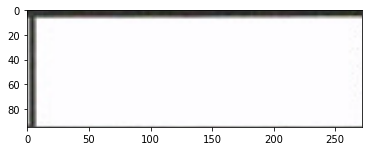

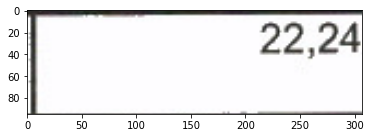

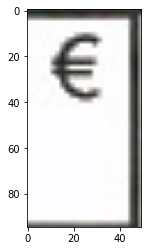

In [12]:
# Computing cells bounding boxes
cells = []

for y in range(len(yLines) - 1):
    tmp = []
    for x in range(len(xLines) - 1):
        tmp.append([xLines[x], yLines[y], xLines[x+1], yLines[y+1]])
    cells.append(tmp)

for i in cells:
    for j in i:
        plt.imshow(image[j[1]:j[3], j[0]:j[2]])
        plt.show()

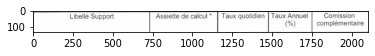

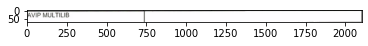

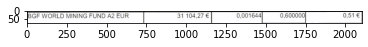

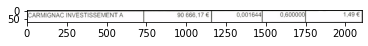

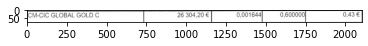

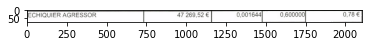

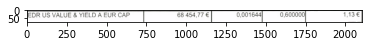

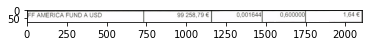

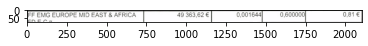

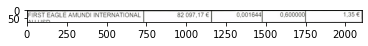

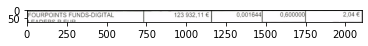

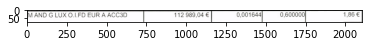

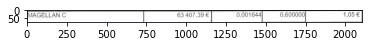

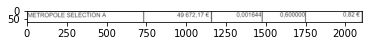

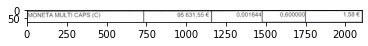

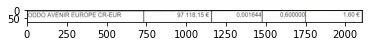

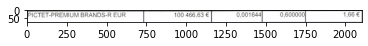

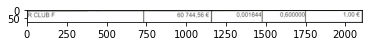

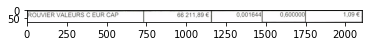

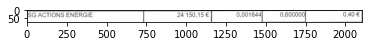

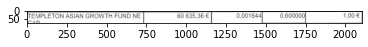

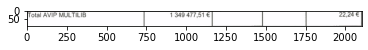

In [13]:
# Computing rows bounding boxes 
rows = []
for y in range(len(yLines) - 1):
    rows.append([xLines[0], yLines[y], xLines[-1], yLines[y+1]])

for i in rows:
    plt.imshow(image[i[1]:i[3], i[0]:i[2]])
    plt.show()
    
numberOfColumns = len(cells[0])

In [15]:
mmocr = MMOCR(det='TextSnake', kie = 'SDMGR')
#details = mmocr.readtext(image, details=True, out_file=None)
# Inference
details = mmocr.readtext(image, details=True)

load checkpoint from http path: https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_r50_fpn_unet_1200e_ctw1500-27f65b64.pth
load checkpoint from http path: https://download.openmmlab.com/mmocr/textrecog/seg/seg_r31_1by16_fpnocr_academic-72235b11.pth
load checkpoint from http path: https://download.openmmlab.com/mmocr/kie/sdmgr/sdmgr_unet16_60e_wildreceipt_20210520-7489e6de.pth


/home/cvk/.local/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/cvk/mmocr/mmocr/datasets/kie_dataset.py:43: UserWarning: KIEDataset is only initialized as a downstream demo task of text detection and recognition without an annotation file.
  warnings.warn(
/home/cvk/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/cvk/mmocr/mmocr/models/kie/extractors/sdmgr.py:162: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings

In [16]:
# centralize all the info we have and will compute into a List for every word detected
results = []
for element in details[0]['result']:
    x = 0
    y = 0
    xs = []
    ys = []
    for idx, i in enumerate(element['box']):
        if idx % 2 == 0:
            xs.append(i)
            x += i
        else:
            ys.append(i)
            y += i
            
    x = round(x / (len(element['box'])/2))
    y = round(y / (len(element['box'])/2))
    
    crop = image[min(ys):max(ys), min(xs):max(xs)]
    config = ("-l fra+equ --oem 3 --psm 11")
    text = pytesseract.image_to_string(crop, config=config)
    
    xIndex = -1
    for xdx in range(len(xLines)-1):
        if x >= xLines[xdx] and x <= xLines[xdx+1]:
            xIndex = xdx
            break
    
    yIndex = -1
    for ydx in range(len(yLines)-1):
        if y >= yLines[ydx] and y <= yLines[ydx+1]:
            yIndex = ydx
            break
    
    results.append({
        'x': x, # x position of the center of the word
        'y': y, # y position of the center of the word
        'text': text.replace('|','').replace('\n',''), # text value of the word
        'xmin':min(xs), # word left side boundary (x value) 
        'xmax':max(xs), # word right side boundary (x value) 
        'ymin':min(ys), # word top side boundary (y value) 
        'ymax':max(ys), # word bottom side boundary (y value) 
        'xIndex':xIndex, # word x index in the grid layout 
        'yIndex':yIndex, # word y index in the grid layout 
    })

<IPython.core.display.Javascript object>


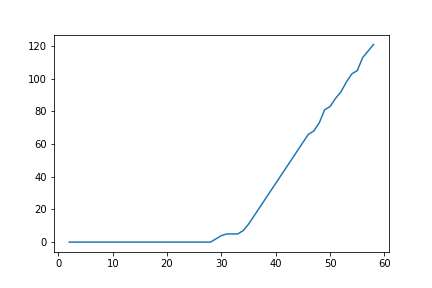

In [17]:
%matplotlib notebook

# Kmeans clustering to find the number and order of the rows


X = np.array([[y['y']] for y in results])
ax = []
ay = []

overlapList = []
ax = []

for c in range(2, len(results)//2):
    kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    centers = [i[0] for i in kmeans.cluster_centers_]
    
    labels = kmeans.labels_
    
    overlap = 0
    
    # Find overlapping element in clusters based on ymin and ymax for each word
    # Overlapping means that a word in a class is also crossed by an other class
    for idx, i in enumerate(centers):
        for jdx, j in enumerate(results):
            if labels[jdx] != idx:
                if i >= j['ymin'] and i <= j['ymax']:
                    overlap += 1
        
    overlapList.append(overlap)
    ax.append(c)
    
    
ax = np.array(ax)
ay = np.array(overlapList)

plt.plot(ax, ay)

In [18]:
def getError(reg, x, y):
    x = [i[0] for i in x]
    y = [i[0] for i in y]
    a = reg.coef_
    b = reg.intercept_
    rv = 0
    for idx, i in enumerate(x):
        rv += (a*i + b - y[idx])**2
    return rv   

In [19]:
# Compute the ideal number of clusters with a double sliding linear regression 

from sklearn.linear_model import LinearRegression
X = [[n] for n in range(len(ay))]
y = [[n] for n in ay]
maxScore = 0
yClusters = 0
for n in range(2, len(ay)-2):
    X1 = X[:n]
    y1 = y[:n]
    X2 = X[n:]
    y2 = X[n:]
    reg1 = LinearRegression().fit(X1, y1)
    reg2 = LinearRegression().fit(X2, y2)
    res = getError(reg1, X1, y1)[0][0] + getError(reg2, X2, y2)[0][0]
    if res > 10:
        yClusters = n
        break

In [20]:
# Now we use the previously calculated value for number of cluster about y values to get the word classified
X = np.array([[y['y']] for y in results])
kmeans = KMeans(n_clusters=yClusters, random_state=42).fit(X)

In [21]:
# add to the result array each word Y label
for ldx,label in enumerate(kmeans.labels_):
    results[ldx]['label'] = label

In [22]:
# Sort the Y clusters center
orderedCenters = [ (i[0], idx) for idx, i in enumerate(kmeans.cluster_centers_)]
orderedCenters.sort(key=lambda x:x[0])

In [23]:
# Create a dict which keys are corresponding to the yIndex for each word and the value is the y Classification
# of the words in this row
rowLabels = {}
for eldix, el in enumerate(rows):
    rowLabels[eldix] = [r[1] for r in orderedCenters if r[0] >= el[1] and r[0] <= el[3]]
rowLabels

{0: [5, 27],
 1: [26],
 2: [9],
 3: [16],
 4: [24],
 5: [0],
 6: [13],
 7: [22],
 8: [8],
 9: [15],
 10: [3],
 11: [20],
 12: [11],
 13: [23],
 14: [7],
 15: [21],
 16: [1],
 17: [18],
 18: [17],
 19: [10],
 20: [19],
 21: [4]}

In [24]:
# Fill the array with all the data at the right place
lineBreak = '\n'
array = [['' for _ in range(numberOfColumns)] for _ in range(len(rows))]

for idx, i in enumerate(array):
    for jdx, j in enumerate(i):
        cellItems = [a for a in results if a['xIndex'] == jdx and a['yIndex'] == idx]
        cellResult = ''
        for labdx, label in enumerate(rowLabels[idx]):
            for item in cellItems:
                if item['label'] == label:
                    cellResult += f"{item['text']} " 
            
            cellResult += lineBreak if labdx < len(rowLabels[idx]) - 1 else ''
                
        array[idx][jdx] = cellResult

In [25]:
# Converting and saving to CSV file
pdResult = pd.DataFrame(np.array(array))
display(HTML(pdResult.to_html()))
pdResult.to_csv('test5.csv', index=False, line_terminator=lineBreak)

,0,1,2,3,4,5
0,Libellé Support \n,Assiette de calcul * \n,Ï Taux quotidien [Taux Annuel \n,\n(%),Comission \ncomplémentaire,\n
1,lAVIP MULTILIB,,,,,
2,BGF WORLD MINING FUND A2 EUR,"31 104,27 €","0,001644","0,6","0,51 €",
3,[CARMIGNAC INVESTISSEMENT A,90 666.17 €,"0,001644",0.600000,"1,49 €",
4,[CM-CIC GLOBAL GOLD C.,"26 304,20 €","0,001644",0.600000,"0,43 €",
5,ECHIQUIER AGRESSOR,"47 269,52 €",0.001644,"0,600000","0,78€",
6,[EDR US VALUE & YIELD À EUR CAP,"68 454,77 €","0,001644","0,600000","1,13€",
7,FF AMERICA FUND À USD.,"99 258,79 €","0,001644","0,600000","1,64 €",
8,FF EMG EUROPE MID EAST & AFRICA,"49 363,62 €",0.001644,0.600000,"0,81 €",
9,[FIRST EAGLE AMUNDI INTERNATIONAL.,"82 097,17 €",0.001644],"0,600000","1,35 €",
